# Preparación
Se monta el sistema de archivos de google drive.


In [21]:
import tensorflow as tf
tf.test.gpu_device_name()

2022-01-08 19:54:22.063704: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


'/device:GPU:0'

2022-01-08 19:54:22.064296: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-08 19:54:22.064615: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-08 19:54:22.065277: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-08 19:54:22.065639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-08 19:54:22.066044: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 1

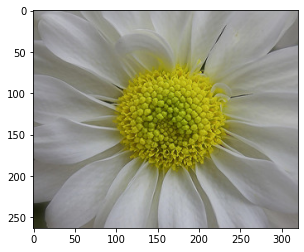

In [22]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('../input/flowers-recognition/flowers/daisy/100080576_f52e8ee070_n.jpg', 'r')
imshow(np.asarray(pil_im))



# Carga del dataset

In [23]:
image_size = (150, 150)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/flowers-recognition/flowers",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/flowers-recognition/flowers",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.


# Modelo

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten, BatchNormalization

In [25]:
model = keras.Sequential()
model.add(Rescaling(scale=(1./127.5),
                    offset=-1, 
                    input_shape=(150, 150, 3)))


model.add(Conv2D(64, kernel_size=(3, 3), padding = "same", activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding = "same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))


model.add(Conv2D(128, kernel_size=(3, 3), padding = "same", activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), padding = "same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))

model.add(Conv2D(256, kernel_size=(3, 3), padding = "same", activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), padding = "same", activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), padding = "same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))

model.add(Conv2D(512, kernel_size=(3, 3), padding = "same", activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding = "same", activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding = "same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))

model.add(Conv2D(512, kernel_size=(3, 3), padding = "same", activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding = "same", activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding = "same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# Visualización del modelo

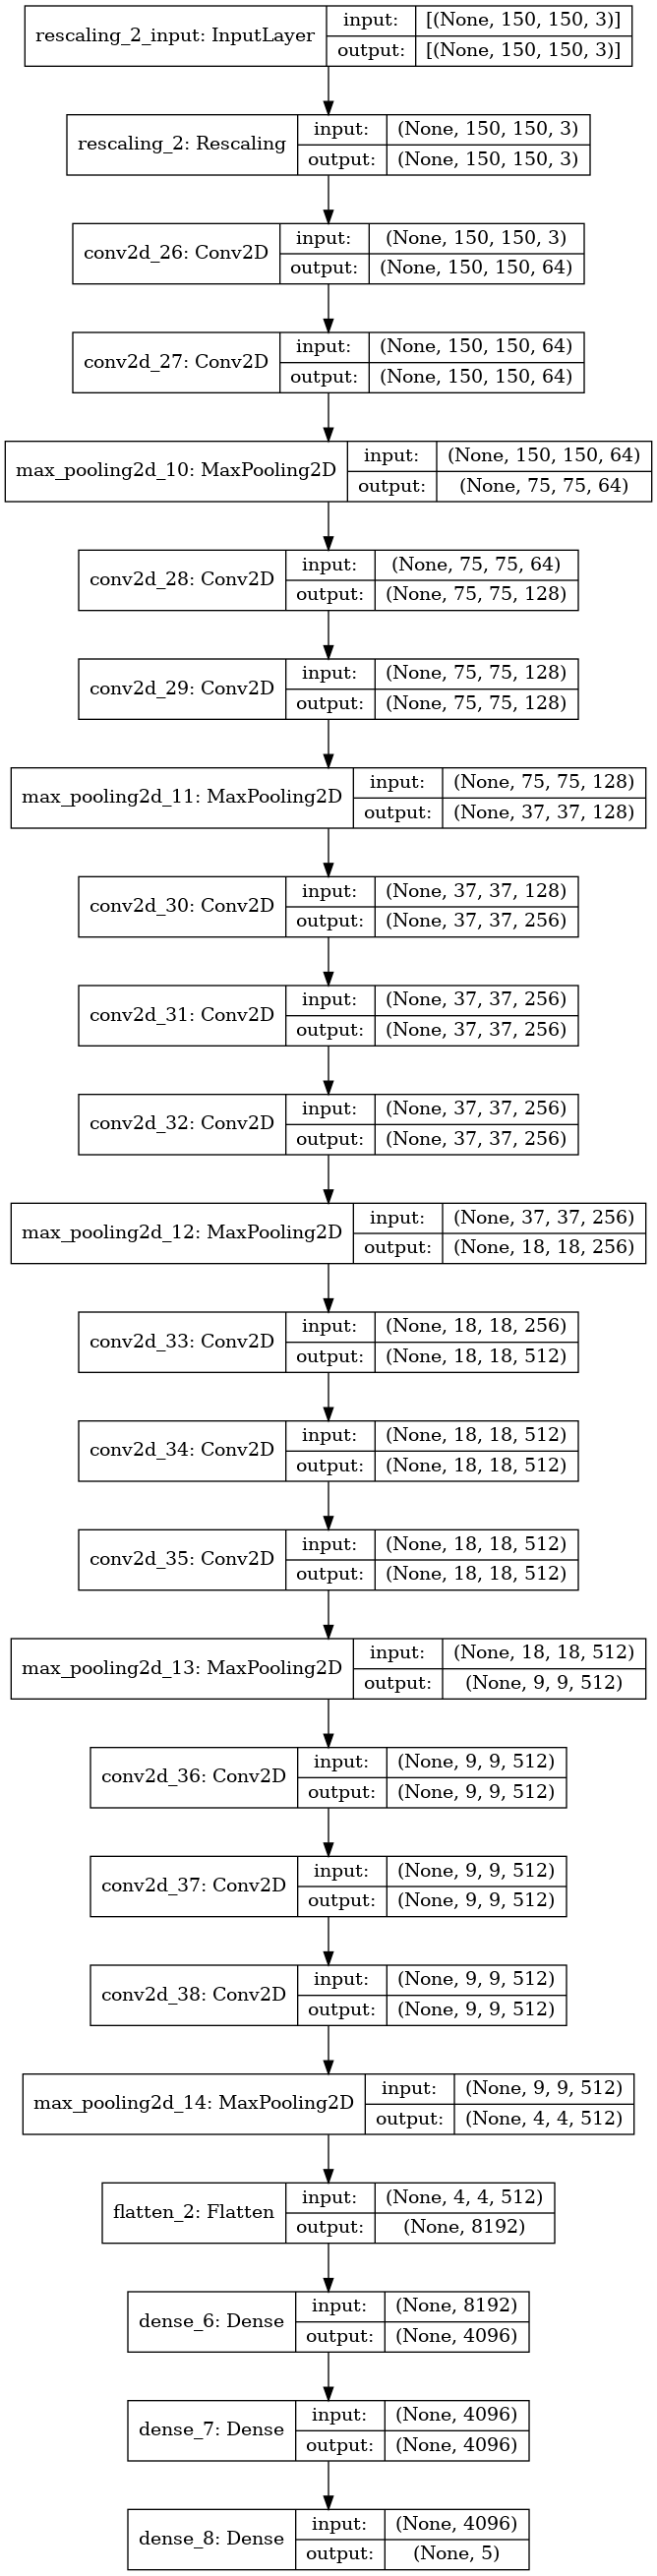

In [26]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True,
           show_layer_names=True)

# Entrenamiento

In [27]:
from keras.callbacks import EarlyStopping

epochs = 200

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=15,
                   restore_best_weights=True)

h = model.fit(
        train_ds,
        epochs=epochs, 
        validation_data=val_ds,
        callbacks = [es]
)

Epoch 1/200
108/108 [==============================] - 16s 136ms/step - loss: 1.6092 - accuracy: 0.2287 - val_loss: 1.6090 - val_accuracy: 0.2213
Epoch 2/200
108/108 [==============================] - 14s 129ms/step - loss: 1.6089 - accuracy: 0.2299 - val_loss: 1.6086 - val_accuracy: 0.2236
Epoch 3/200
108/108 [==============================] - 14s 129ms/step - loss: 1.6086 - accuracy: 0.2362 - val_loss: 1.6083 - val_accuracy: 0.2294
Epoch 4/200
108/108 [==============================] - 14s 128ms/step - loss: 1.6084 - accuracy: 0.2441 - val_loss: 1.6080 - val_accuracy: 0.2514
Epoch 5/200
108/108 [==============================] - 15s 133ms/step - loss: 1.6081 - accuracy: 0.2548 - val_loss: 1.6077 - val_accuracy: 0.2677
Epoch 6/200
108/108 [==============================] - 14s 128ms/step - loss: 1.6079 - accuracy: 0.2716 - val_loss: 1.6074 - val_accuracy: 0.2851
Epoch 7/200
108/108 [==============================] - 14s 130ms/step - loss: 1.6076 - accuracy: 0.2860 - val_loss: 1.6071 -

# Gráfica de evolución de pérdida y exactitud durante el entrenamiento

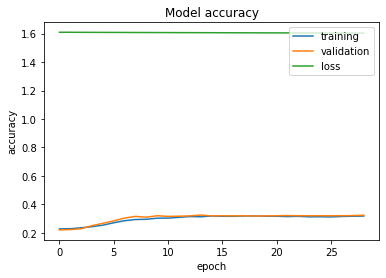

In [28]:
import matplotlib.pyplot as plt

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.plot(h.history['loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation','loss'], loc='upper right')
plt.show()

# Evaluación de los resultados

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.7521    0.3667    0.4930       480
           2     0.0000    0.0000    0.0000         0
           3     0.0000    0.0000    0.0000         0
           4     0.5497    0.2742    0.3659       383

    accuracy                         0.3256       863
   macro avg     0.2604    0.1282    0.1718       863
weighted avg     0.6623    0.3256    0.4366       863



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


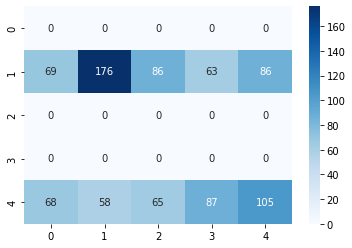

In [29]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

results = np.concatenate([(y, model.predict(x=x)) for x, y in val_ds], axis=1)

predictions = np.argmax(results[0], axis=1)
labels = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

print(classification_report(labels, predictions, digits = 4))

In [30]:
img = keras.preprocessing.image.load_img(
    '../input/flowers-recognition/flowers/daisy/10172636503_21bededa75_n.jpg', target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(np.argmax(predictions[0]))

1
